BDMLtools构建梯度提升模型  <font size=3 >by 曾珂</font>

**环境**:
+ **OS**: macOS Big Sur 11.5.2
+ **CPU**: 2GHz 四核Intel Core i5
+ **内存**: 16G

In [1]:
import pandas as pd
import numpy as np
import BDMLtools as bm
import lightgbm
import xgboost
import catboost
import sklearn

In [2]:
print("BDMLtools v"+str(bm.__version__))
print("sklearn v"+str(sklearn.__version__))
print("lightgbm v"+str(lightgbm.__version__))
print("xgboost v"+str(xgboost.__version__))
print("catboost v"+str(catboost.__version__))

BDMLtools v0.4.5
sklearn v1.5.1
lightgbm v4.5.0
xgboost v2.0.3
catboost v1.2.5


In [3]:
np.int=int

# 1 数据说明

+ 此数据为外国某消费金融公司的某个人消费类贷款产品数据,客群大多拥有信用记录,要求在贷款准入节点构建评分卡评估客群信用风险,为贷中审批,授信定价提供参考。

+ 原始数据包括客户的申请信息,外部数据,征信信息,历史申请信息(若有),历史贷款表现(若有)五类信息,分散于不同的表中,这里已经进行了特征构建与宽表构建

+ 原始数据共20万样本,5000多个特征,这里为简化选择原数据中的122个特征与随机3万的样本演示

+ 特征含义见下:


```
1.申请及外部数据字段
 ID':订单编号
 TARGET:目标变量
 GENDER':性别(F,M)
 Age:年龄
 FLAG_OWN_CAR:是否有车
 OWN_CAR_AGE:拥有车时长
 HOUSING_TYPE:住房类型
 FLAG_OWN_REALTY:是否有房产
 NUM_CHILDREN':子女个数
 EDULEVEL:教育水平
 MARRIAGE':婚姻状况
 DAYS_EMPLOYED:工作时长天
 DAYS_LAST_PHONE_CHANGE':以往申请记录中联系方式变更距今时长天
 DAYS_ID_PUBLISH:以往申请记录中变更申请的身份材料时长天
 CITY_RATING:居住城市综合水平评级
 score1:外部信用评分1
 score2:外部信用评分2
 score3:外部信用评分3
2.征信记录
 Bureau_Var102:近18月最大授信金额_在贷
 Bureau_Var1033:最大授信使用率_所有
 Bureau_Var1036:近24月最大授信使用率_所有
 Bureau_Var1044:近24月平均授信使用率_所有
 Bureau_Var1048:近24月平均授信使用率_在贷
 Bureau_Var1060:近24月平均授信使用率_所有_信用卡
 Bureau_Var1061:平均授信使用率_在贷_信用卡
 Bureau_Var1068:近24月最大授信使用率_所有_贷款
 Bureau_Var1069:最大授信使用率_在贷_贷款
 Bureau_Var1072:近24月最大授信使用率_在贷_贷款
 Bureau_Var1075:近12月平均授信使用率_所有_贷款
 Bureau_Var1089:平均授信使用率_所有_消费金融
 Bureau_Var109:近15月平均授信金额_所有
 Bureau_Var1096:近24月平均授信使用率_在贷_消费金融
 Bureau_Var1098:180天以内贷款笔数_所有
 Bureau_Var112:平均授信金额_所有
 Bureau_Var1120:征信到期日前360天贷款笔数_在贷_贷款
 Bureau_Var1123:征信到期日前270天贷款笔数_所有_消费金融
 Bureau_Var1129:已结清征信90天贷款笔数_所有
 Bureau_Var1132:已结清征信360天贷款笔数_所有
 Bureau_Var1149:已结清征信90天贷款笔数_在贷_贷款
 Bureau_Var1152:已结清征信360天贷款笔数_在贷_贷款
 Bureau_Var1153:已结清征信90天贷款笔数_所有_消费金融
 Bureau_Var1157:已结清征信90天贷款笔数_在贷_消费金融
 Bureau_Var1159:已结清征信270天贷款笔数_在贷_消费金融
 Bureau_Var116:近1年平均授信金额_在贷
 Bureau_Var1160:已结清征信360天贷款笔数_在贷_消费金融
 Bureau_Var117:近15月平均授信金额_在贷
 Bureau_Var120:平均授信金额_在贷
 Bureau_Var124:近1年授信金额标准差_所有
 Bureau_Var128:授信金额标准差_所有
 Bureau_Var136:平均授信金额标准差_在贷
 Bureau_Var140:近1年最大负债_所有
 Bureau_Var141:近15月最大负债_所有
 Bureau_Var142:近18月最大负债_所有
 Bureau_Var150:近18月最大负债_在贷
 Bureau_Var156:近1年总负债_所有
 Bureau_Var159:近2年总负债_所有
 Bureau_Var19:近6月客户贷款数_在贷
 Bureau_Var21:近15月客户贷款数_在贷
 Bureau_Var22:近18月客户贷款数_在贷
 Bureau_Var24:客户贷款数_在贷
 Bureau_Var248:最大历史逾期金额_所有_信用卡
 Bureau_Var272:贷款平均最大历史逾期金额_在贷_信用卡
 Bureau_Var304:最大授信金额_在贷_信用卡
 Bureau_Var311:近2年平均授信金额_所有_信用卡
 Bureau_Var312:平均授信金额_所有_信用卡
 Bureau_Var317:近15月平均授信金额_在贷_信用卡
 Bureau_Var320:平均授信金额_在贷_信用卡
 Bureau_Var328:授信金额标准差_所有_信用卡
 Bureau_Var342:近18月最大负债_所有_信用卡
 Bureau_Var343:近2年最大负债_所有_信用卡
 Bureau_Var359:近2年总负债_所有_信用卡
 Bureau_Var368:总负债_在贷_信用卡
 Bureau_Var416:客户贷款数_结清_贷款
 Bureau_Var448:最大历史逾期金额_所有_贷款
 Bureau_Var48:最大历史逾期金额_所有
 Bureau_Var492:近1年最大授信金额_所有_贷款
 Bureau_Var494:近18月最大授信金额_所有_贷款
 Bureau_Var496:最大授信金额_所有_贷款
 Bureau_Var499:近6月最大授信金额_在贷_贷款
 Bureau_Var5:近15月客户贷款数_所有
 Bureau_Var507:近6月平均授信金额_所有_贷款
 Bureau_Var515:近6月平均授信金额_在贷_贷款
 Bureau_Var516:近1年平均授信金额_在贷_贷款
 Bureau_Var526:近18月授信金额标准差_所有_贷款
 Bureau_Var536:平均授信金额标准差_在贷_贷款
 Bureau_Var558:近18月总负债_所有_贷款
 Bureau_Var56:贷款平均最大历史逾期金额_所有
 Bureau_Var560:总负债_所有_贷款
 Bureau_Var568:总负债_在贷_贷款
 Bureau_Var616:客户贷款数_结清_消费金融
 Bureau_Var664:最大历史逾期金额_在贷_消费金融
 Bureau_Var680:贷款展期总次数_在贷_消费金融
 Bureau_Var688:贷款展期总次数_所有_消费金融
 Bureau_Var694:近18月最大授信金额_所有_消费金融
 Bureau_Var700:近1年最大授信金额_在贷_消费金融
 Bureau_Var701:近15月最大授信金额_在贷_消费金融
 Bureau_Var704:最大授信金额_在贷_消费金融
 Bureau_Var707:近6月平均授信金额_所有_消费金融
 Bureau_Var708:近1年平均授信金额_所有_消费金融
 Bureau_Var709:近15月平均授信金额_所有_消费金融
 Bureau_Var716:近1年平均授信金额_在贷_消费金融
 Bureau_Var751:近2年最大负债_在贷_消费金融
 Bureau_Var755:近6月总负债_所有_消费金融
 Bureau_Var765:近15月总负债_在贷_消费金融
 Bureau_Var806:近15月最大信用卡额度_所有_信用卡
 Bureau_Var807:近18月最大信用卡额度_所有_信用卡
 Bureau_Var94:近18月最大授信金额_所有
 Bureau_Var96:最大授信金额_所有  
3.以往的逾期/还款类字段
 IP_Var24:近24月贷款最大逾期天数
 IP_Var30:近24月逾期期数占所有期数比例
 IP_Var31:提前还款期数占所有期数比例
 IP_Var36:近24月提前还款期数占所有期数比例
4.以往的申请记录
 Previous_Var22:近24月贷款申请次数
 Previous_Var289:贷款申请平均金额_通过_CashLoan
 Previous_Var49:贷款申请平均金额_通过
 Previous_Var53:近12月贷款申请平均金额_通过
 Previous_Var536:近24月贷款申请平均金额_通过_ConsumerLoan
 Previous_Var545:贷款申请总金额_通过_ConsumerLoan
 Previous_Var56:近24月贷款申请平均金额_通过
 Previous_Var63:近18月贷款申请最大金额_通过
 Previous_Var64:近24月贷款申请最大金额_通过
```

# 2 数据处理

以Pipline工作流的形式进行数据处理,各个函数作用请见其文档

    Step 1.dtStandardization:实体一致性转换
    Step 2.dtypeAllocator:列类型分配转换
    Step 3.nanTransformer:缺失值处理
    Step 4.outliersTransformer:异常值处理

In [4]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(
    
    [('1.dtStandardization',bm.dtStandardization(id_col=['ID'],drop_dup=True)), 
                 
     ('2.dtypeAllocator', bm.dtypeAllocator(dtypes_dict={})),
                 
     ('3.nanTransformer',bm.nanTransformer(method=('constant','constant'),
                                         missing_values=[np.nan,np.inf,-np.inf,'nan','','special','missing'],
                                         fill_value=(np.nan,'missing'),
                                         indicator=False)),
    
     ('4.outliersTransformer', bm.outliersTransformer())     
    ])                           

In [5]:
dat=pipe.fit_transform(pd.read_csv('data/creditdata_small.csv'))

# 3 数据分区

本案例只考虑in-sample分区

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test=train_test_split(dat.drop('TARGET',axis=1),
                                                  dat['TARGET'],
                                                  test_size=0.33, 
                                                  random_state=1223,stratify=dat['TARGET'])

# 4 预拟合模型

bm.prefitModel为预拟合模型，提供了在不进行任何特征筛选的前提下使用全量数据建模以预估模型效果的功能

若后续特征筛选过程合理则模型表现不会差距过多，甚至会比预拟合模型好

+ 此步骤并非必须
+ 默认使用lightgbm作为训练算法
+ 更多详请请见帮助文档

In [8]:
p_model=bm.prefitModel().fit(X_train,y_train)

+ 模型表现

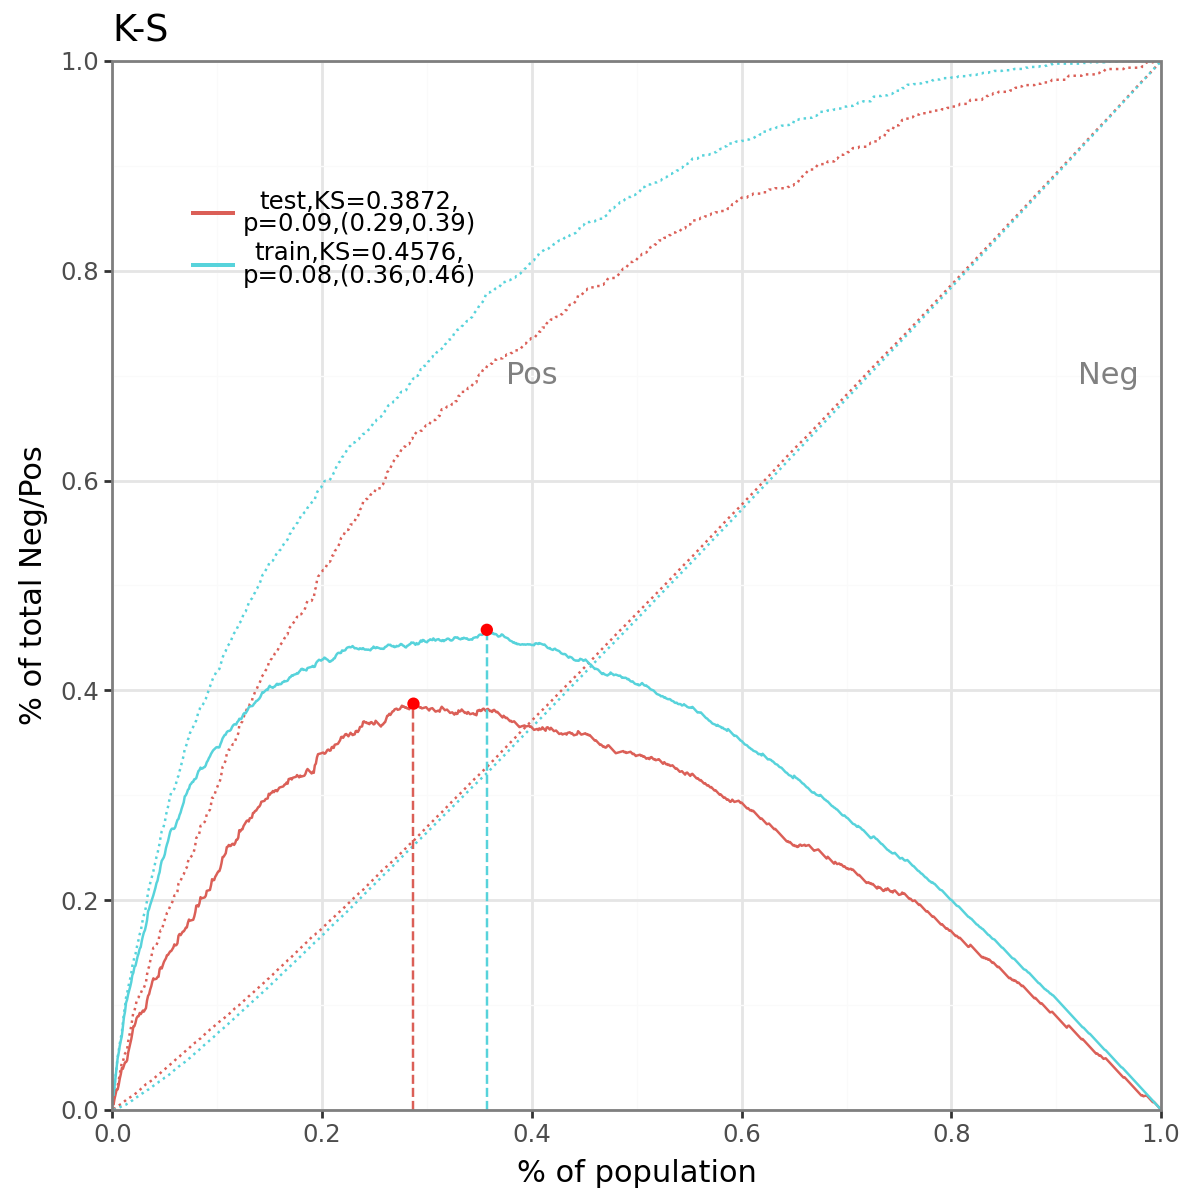

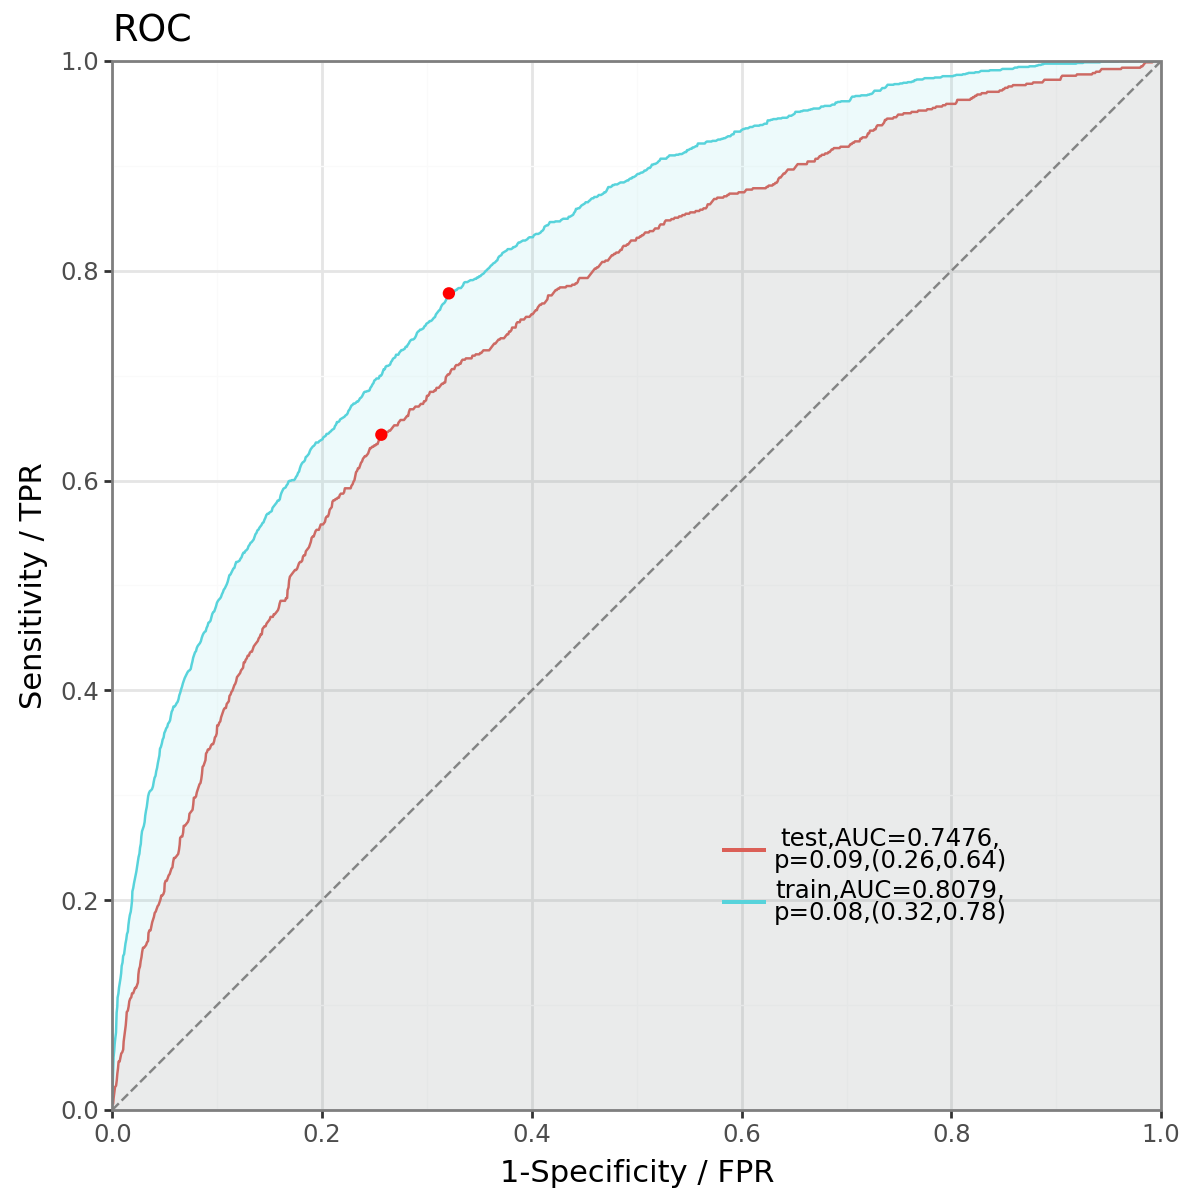

{'ks': <Figure size 600x600 with 1 Axes>,
 'roc': <Figure size 600x600 with 1 Axes>}

In [9]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(p_model.predict_proba(X_train),index=X_train.index),
    pd.Series(p_model.predict_proba(X_test),index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) #可以看到test数据上ks与auc的情况,此结果可作为模型结果的参考值

# 5 特征筛选

**特征筛选目标**:尽可能得减少入模特征个数同时不损失模型的预测能力

**特征筛选思想**:贪婪搜索(Greedy Search)

+ 贪婪简单过滤(Simple Filters):实现:bm.preSelector
+ 递归特征消除(Recursive Feature Elimination):实现:bm.LgbmShapRFECVSelector
+ 逐步特征选择(Stepwise Selection):实现:bm.LgbmSeqSelector

**已知缺陷**

+ 容易过拟合
+ 计算量较大

后续将展示上述内容的Python实现

**参考资料**:

+ [Feature Engineering and Selection #10.1 Goals of Feature Selection](https://bookdown.org/max/FES/goals-of-feature-selection.html)

+ [Feature Engineering and Selection #11.2 Simple Filters](https://bookdown.org/max/FES/greedy-simple-filters.html)

+ [Feature Engineering and Selection #11.3 Recursive Feature Elimination](https://bookdown.org/max/FES/recursive-feature-elimination.html)

+ [Feature Engineering and Selection #11.4 Stepwise Selection](https://bookdown.org/max/FES/greedy-stepwise-selection.html)


## 5.1 简单筛选

预筛:当特征数量过多时，快速筛选掉无用特征

bm.preSelector提供了类似的功能,能够快速过滤掉那些**非常不重要的特征**

    Step 1.缺失值(所有):缺失率高于用户定义值的列将被筛除
    Step 2.唯一值(所有):唯一值占比高于用户定义值列将被筛除
    Step 3.方差(数值特征):方差低于用户定义值列的列将被筛除
    Step 4.卡方独立性检验p值(字符)/方差分析p值(数值):p值大于用户定义值的列将被剔除(不支持样本权重)
    Step 5.Lightgbm筛选(所有):split重要性低于用户定义值的列将被剔除
    Step 6.Iv值筛选(所有):等频30箱后iv值低于用户定义值的列将被剔除
    
详见帮助文档

In [10]:
pre=bm.preSelector(
    na_pct=0.95, #缺失率高于na_pct的列将被筛除
    unique_pct=0.95,#唯一值占比高于unique_pct的列将被筛除
    variance=0,#方差低于variance的列(连续)将被筛除
    chif_pvalue=0.05,#大于chif_pvalue的列将被剔除
    tree_imps=1,#split_gain小于等于tree_imps的列将被剔除
    tree_size=250,#LGBM树个数
    iv_limit=0.02 #iv小于等于iv_limit的特征将被踢出
).fit(X_train,y_train)

-----------------------------------------------Start------------------------------------------------
                       1.filterbyNA______________________________Done.
                       2.filterbyUniquepct_______________________Done.
                       3.filterbyVariance________________________Done.
                       4.filterbyChi2Oneway______________________Done.
                       5.filterbyTrees___________________________Done.
                       6.filterbyIV______________________________Done.
------------------------------------------------Done------------------------------------------------
Step:0.orgin,features remain:119
Step:1.filterbyNA,features remain:114
Step:2.filterbyUnique,features remain:114
Step:3.filterbyVariance,features remain:114
Step:4.filterbyChi2Oneway,features remain:109
Step:5.filterbyTrees,features remain:107
Step:6.filterbyIV,features remain:102


In [11]:
X_train_1=pre.transform(X_train) #数据经transform后过滤掉了无用特征
X_test_1=pre.transform(X_test) 

案例数据中的特征的预测能力都比较强，预筛选过程中有少量特征被筛选掉

## 5.2 递归式特征消除

基于交叉验证的递归式特征消除(Recursive feature elimination with cross-validation)是一种机器学习特征筛选方法，其利用基模型(必须拥有属性_coef或_feature_importance)的特征重要性指标进行特征筛选:

sklearn.feature_selection.RFE筛选过程:

    1.指定基模型、保留的特征数量(n_features_to_select参数控制)
    2.拟合模型，输出特征权重
    3.将特征权重较小的一部分特征(step参数控制)消除
    4.重复步骤2,3直到保留的特征数量=n_features_to_select

sklearn.feature_selection.RFECV筛选过程:

    1.指定基模型、最小保留的特征数量(min_features_to_select),交叉验证参数(cv),模型评价指标(scoring),RFE步长(step)等
    2.按照交叉验证参数设定进行切分数据
    3.在不同的交叉验证数据上进行RFE(n_features_to_select,step...)拟合并记录每一步特征消除的在验证数据上评价指标(scoring),剩余特征数量,可选择并行
    4.对交叉验证数据的评价指标(scoring)进行平均，并选择最高指标下的剩余特征数量作为n_select,以max(n_select,min_features_to_select)作为特征筛选个数
    5.再进行RFE(n_features_to_select=max(n_select,min_features_to_select))拟合全量数据并得到具体筛选的特征

Sklearn中的RFE,RFECV提供了进行递归式特征消除的实现,但在实践中会有一些问题(Sklearn版本v1.0.2):
    
    1.对非sklearn生态的模型兼容性不佳,例如对boosting模型(Lgbm,xgboost,catboost等)
    2.不支持传递更多的fit_params,例如sample_weight
    3.在每一步的消除过程中的特征集并非最优超参条件下,而是固定超参数,因此筛选结果可能有一定偏差
    4.重要性方面,树模型里常见的gini,entropy,split,gradient重要性倾向选择唯一值较多的特征(数值特征与水平较多的分类特征),而回归模型在不加入正则的条件下容易出现过拟合导致_coef不准确,加入正则的_coef本身是有偏差的且无法对此超参优化从而导致_coef产生一定偏差
    

参考资料:
+ [Sklearn中RFE介绍](https://scikit-learn.org/stable/modules/feature_selection.html#rfe)
+ [Sklearn中RFE源码](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/feature_selection/_rfe.py)

##### RFE with CV与改进

很多研究者们尝试改进RFE算法以使结果更加稳健，一种思路是使用可支持Shap值、支持boosting模型、交叉验证与参数优化的RFE,此类算法的实现可参考shap-hypetune、probatus等

**probatus**的作者来自Ing银行的数据科学团队,其改进版ShapRFECV/EarlyStoppingShapRFECV算法是一种基于SHAP重要性的RFE算法,其基本实现了对sklearn中RFE的改进:
    
    1.使用CV验证数据中的Average Shap value作为特征重要性的度量
    2.对Lgbm,xgboost,catboost等集成模型进行了定制,可支持更多的fit_params如early_stopping,cat_features,sample_weight等    
    3.可支持对每一步消除过程中的基模型进行超参数调优(sklearn中的GridSearchCV,RandomizedSearchCV,skopt中的BayesSearchCV)    
    
**shap-hypetune**的RFE其实现效果与probatus类似,读者可在参考资料中了解
    
关于SHAP值，其度量了各个特征在某一样本上对于模型结果的贡献，其一般用于解释机器学习模型，同时特征在各个样本上SHAP值的均值也可以用于度量其重要性。

结合SHAP重要性的RFE算法过程如下:

+ ShapRFECV算法过程:
    
        1.[可选]支持贝叶斯(sklearn-optimize:BayesSearchCV)、随机网格(sklearn:RandomizedSearchCV)、暴力网格(sklearn:GridSearchCV)优化对象传入并在每一轮特征筛选时先对基模型进行超参数优化

        2.使用交叉验证技术，每一轮在训练集上训练模型并在验证集上产生各个特征的SHAP重要性(基于Python的shap库)
        3.基于各个特征的SHAP重要性在每一轮剔除掉重要性较低的一个或一部分变量，循环上述步骤直到变量个数达到预定要求
    
+ EarlyStoppingShapRFECV算法:

        当基模型为boosting模型时(catboost,lightgbm,xgboost),可以使用这些交叉验证中的验证数据和boosting模型的EarlyStopping功能进一步优化的模型，其他步骤与ShapRFECV类似


笔者对ShapRFECV、EarlyStoppingShapRFECV进行了进一步的整合与封装(bm.LgbmShapRFECVSelector),可实现基模型为LGBMClassifier的RFE特征筛选

其中选择LightGBM作为基模型的理由:

+ tree-based boosting模型预测能力强
+ 可处理缺失值,可处理分类特征,因此对原始数据无需过多的复杂处理
+ 算法运行效率高于同类模型,尤其在使用交叉验证时模型训练时间得以大大缩短

当然boosting模型更容易过度拟合,因此选择合适的评估指标和交叉验证参数是必要的

参考资料
+ [SHAP介绍](https://shap.readthedocs.io/en/latest/)
+ [SHAP源码](https://github.com/slundberg/shap)
+ [ShapRFECV介绍](https://medium.com/ing-blog/open-sourcing-shaprfecv-improved-feature-selection-powered-by-shap-994fe7861560)
+ [ShapRFECV源码](https://github.com/ing-bank/probatus/blob/main/probatus/feature_elimination/feature_elimination.py)
+ [shap-hypetune介绍](https://towardsdatascience.com/shap-for-feature-selection-and-hyperparameter-tuning-a330ec0ea104)
+ [shap-hypetune源码](https://github.com/cerlymarco/shap-hypetune)

In [12]:
import warnings 
warnings.simplefilter('default')

In [13]:
%%time
rfe_shapcv=bm.LgbmShapRFECVSelector(step=1,min_features_to_select=1,early_stopping_rounds=None,n_jobs=-1,
                                 method='random',scoring='roc_auc',cv=5).fit(X_train_1.copy(),y_train.copy(),
                                                                         check_additivity=False)

CPU times: user 50min 33s, sys: 2min 42s, total: 53min 16s
Wall time: 10min 50s


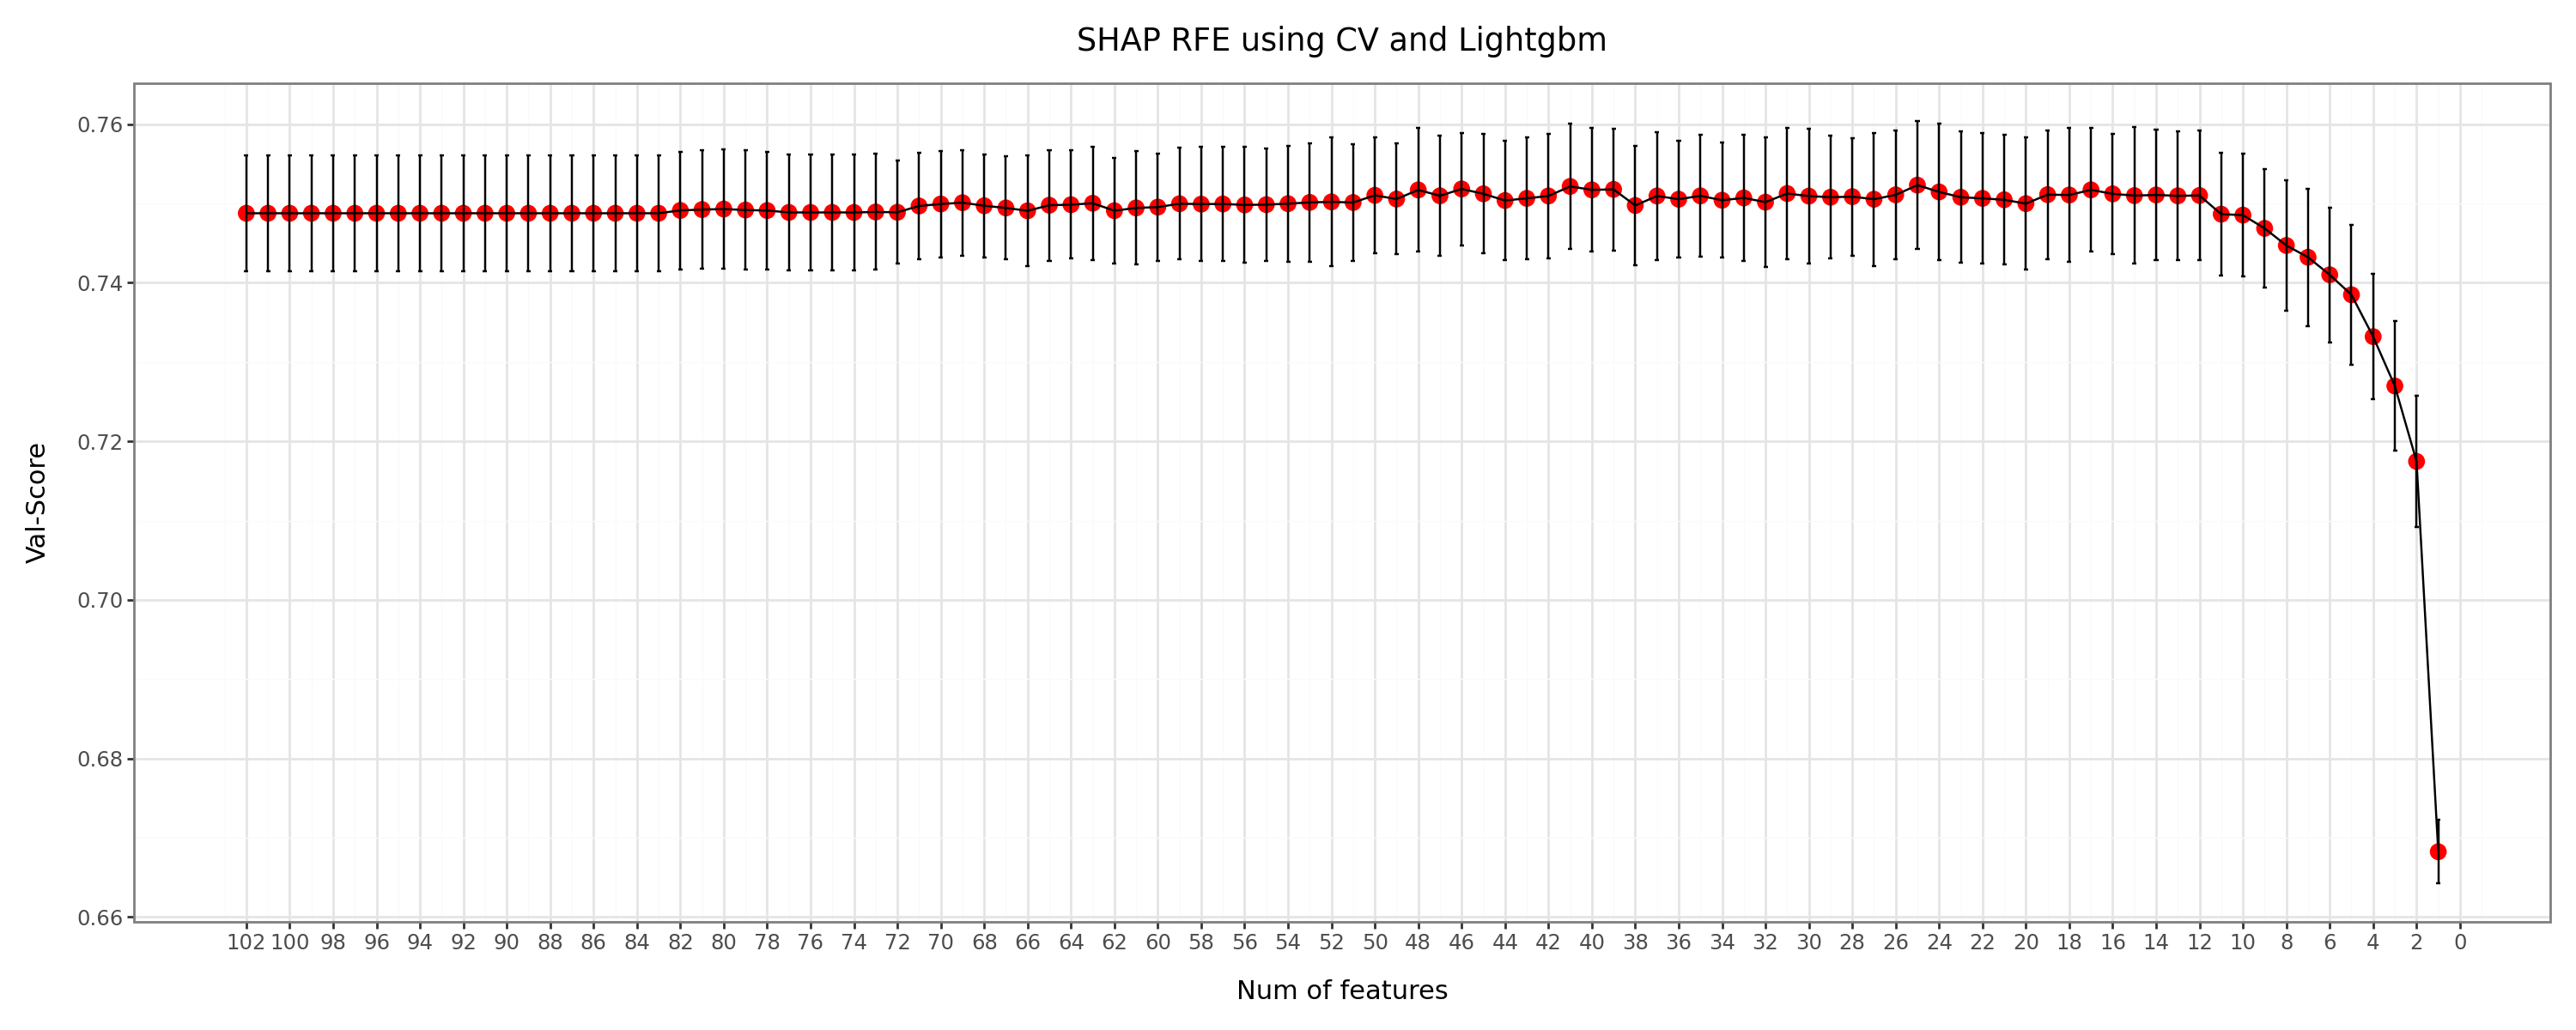

In [14]:
rfe_shapcv.plot(figure_size=(15,6)) #验证数据评估指标与入模特征个数关系图(errorbar_plot)

In [15]:
rfe_shapcv.clf.report_df.sort_values(['val_metric_mean']).tail(10)

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
58,45,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Bureau_Var320],0.816258,0.003550,0.751217,0.015005
72,31,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Bureau_Var156],0.818791,0.003335,0.751252,0.016510
79,24,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Bureau_Var21],0.814855,0.002557,0.751453,0.017265
55,48,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Previous_Var289],0.816779,0.002845,0.751708,0.015545
86,17,"[Bureau_Var1048, Bureau_Var128, Bureau_Var24, ...",[DAYS_LAST_PHONE_CHANGE],0.783097,0.003888,0.751713,0.015588
63,40,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Bureau_Var1044],0.814855,0.003835,0.751713,0.015598
64,39,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Bureau_Var22],0.814433,0.003060,0.751774,0.015374
57,46,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Bureau_Var136],0.816405,0.003299,0.751828,0.014171
62,41,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Bureau_Var558],0.814748,0.003696,0.752148,0.015761
78,25,"[Bureau_Var96, Bureau_Var1089, Bureau_Var1048,...",[Previous_Var22],0.815579,0.002623,0.752312,0.016080


In [16]:
X_train_3_rfe=rfe_shapcv.transform(X_train_1,features_to_select=25) #假定选择17个
X_test_3_rfe=rfe_shapcv.transform(X_test_1,features_to_select=25) #假定选择17个

## 5.3 序列式特征选择

序列式特征消除(Sequential Feature Selection)是一种机器学习特征筛选方法，其思想类似于统计学方法中的逐步回归

+ Sequential Forward Selection (SFS):前向序列特征选择
+ Sequential Backward Selection (SBS):后向序列特征选择
+ Sequential Forward Floating Selection (SFFS):前向-后向序列特征选择
+ Sequential Backward Floating Selection (SBFS):后向-前向序列特征选择

**SFS算法过程(向前法)**

    1.指定基模型、序列法方向(direction),保留的特征数量(n_features_to_select),交叉验证参数(cv),模型评价指标(scoring)等
    2.根据序列法方向(direction)进行特征消除:
        + 'foreward':根据交叉验证数据上的模型评价指标(scoring)从候选特征中逐步得加入最优特征组成模型
    3.重复步骤2直到选择出的特征数量=n_features_to_select
    
**SBS算法过程(向后法)**

    1.指定基模型、序列法方向(direction),保留的特征数量(n_features_to_select),交叉验证参数(cv),模型评价指标(scoring)等
    2.根据序列法方向(direction)进行特征消除:       
        + 'backward':根据交叉验证数据上的模型评价指标(scoring)从候选特征中逐步得减少最差特征组成模型
    3.重复步骤2直到选择出的特征数量=n_features_to_select

**SFFS算法过程(逐步法)**

    1.首先执行SFS,在特征集中添加一个能够使交叉验证集评估函数最优化的特征构建模型并将此特征更新到特征集(已加入)中
    2.再尝试从已选择的特征集中剔除一个能够使交叉验证集上评估函数最优化特征,若无任何特征能使评估函数优化则略过
    3.重复执行步骤1,步骤2直到选择出的特征数量=n_features_to_select

**SBFS算法过程(逐步法)**

    1.首先执行SBS,在特征集中剔除一个能够使交叉验证集评估函数最优化的特征构建模型并将此特征更新到特征集(已剔除)中
    2.再尝试从已剔除的特征集中加入一个能够使交叉验证集评估函数最优化的特征,若无任何特征能使评估函数优化则略过
    3.重复执行步骤1,步骤2直到选择出的特征数量=n_features_to_select
    
**对比**:Sequential Feature Selection算法与统计学方法中的逐步回归非常类似,向前法对应SFS、向后法SBS、逐步法对应SFFS与SBFS,但又有一些细节不同

    1.传统统计是在小数据场景中没有交叉验证的概念,而Sequential Feature Selection则利用了机器学习中的交叉验证技术
    2.逐步回归一般仅限于多元统计中的经典回归类模型,而Sequential Feature Selection则可适用于任何的机器学习模型
    3.逐步回归一般以AIC,BIC等为评估指标,倾向于平衡模型复杂程度与模型表现，而Sequential Feature Selection的评估指标则主要以模型表现为主

总体而言Sequential Feature Selection算法可以视为机器学习版本的逐步法实现,其更适合大数据场景下的特征筛选任务


实践中Sklearn中的SequentialFeatureSelector有以下不足:

    1.目前只支持SFS与SBS,不支持SFFS与SBFS
    2.对非sklearn生态的模型兼容性不佳,例如对boosting模型(Lgbm,xgboost,catboost等)
    3.不支持传递更多的fit_params,例如sample_weight
    4.在每一步的逐步过程中的特征集并非最优超参条件下,而是固定超参数,因此筛选结果可能有一定偏差
    5.计算量大较为耗时
    
而mlxtend中的SquentialFeatureSelector可支持四种序列算法,也可支持传递基模型的fit_params,但其不足表现为:

    1.对boosting模型的支持不佳,无法支持分类特征(lightgbm与Catboost),不支持early_stopping
    2.在每一步的逐步过程中的特征集并非最优超参条件下,而是固定超参数,因此筛选结果可能有一定偏差
    3.计算量大较为耗时
    
这里笔者将LightGBM与Python机器学习库mlxtend中的SequentialFeatureSelector进行了集成用于商业分析场景中机器学习项目的特征筛选(bm.LgbmSeqSelector)

其中选择LightGBM作为基模型的理由:

+ 可处理缺失值,可处理分类特征,因此对原始数据无需过多的复杂处理
+ 算法运行效率高于同类模型,尤其在使用交叉验证时模型训练时间得以大大缩短

当然boosting模型更容易过度拟合,因此选择合适的评估指标和交叉验证参数是必要的

目前不支持分类特征与early_stopping

参考资料:
+ [sklearn中SequentialFeatureSelector介绍](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection)
+ [sklearn中SequentialFeatureSelector源码](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/feature_selection/_sequential.py)
+ [mlxtend中SequentialFeatureSelector介绍](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)
+ [mlxtend中SequentialFeatureSelector源码](https://github.com/rasbt/mlxtend/blob/master/mlxtend/feature_selection/sequential_feature_selector.py)

In [17]:
#%%time
#seq=bm.LgbmSeqSelector(forward=True,floating=False,k_features=10,
#                       scoring='roc_auc',n_jobs=-1).fit(X_train_1,y_train)#向前逐步法:计算量过大仅选10个以示例

In [18]:
#seq.plot(figure_size=(15,6)) ##验证数据评估指标与入模特征个数关系图(errorbar_plot)

In [19]:
#X_train_2_seq=seq.transform(X_train_1)
#X_test_2_seq=seq.transform(X_test_1)

# 6 建模

## 6.1 超参数优化

超参数优化方法:
    
+ 经验超参数
+ [暴力网格搜索(GridSearchCV)](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
+ [随机网格搜索(RandomizedSearchCV)](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)
+ [减半网格搜索(HalvingGridSearchCV)](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving):注意目前sklearn的1.2.1版本中为实验算法
+ [随机减半网格搜索(HalvingRandomSearchCV)](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving):注意目前sklearn的1.2.1版本中为实验算法
+ [贝叶斯优化(Scikit-Optimize)](https://scikit-optimize.github.io/dev/index.html)

此外BayesianOpt,hyperopt,optuna也是受欢迎的贝叶斯优化实现,这里参考资料如下:
+ [hyperopt](https://github.com/hyperopt/hyperopt)
+ [optuna](https://github.com/optuna/optuna)
+ [BayesianOptimization](https://github.com/fmfn/BayesianOptimization)

这里笔者对网格搜索、减半网格搜索、贝叶斯优化算法与LightGBM,Xgboost,Catboost进行了集成,详见帮助文档

+ bm.BayesianCVTuner:基于LightGB\Xgboost\Catboost的贝叶斯优化(Scikit-Optimize作为超参优化方法实施,其与Sklearn兼容性更好)
+ bm.girdTuner:基于LightGB\Xgboost\Catboost的暴力网格\随机网格优化
+ bm.hgirdTuner:基于LightGB\Xgboost\Catboost的减半网格\随机减半网格优化

## 6.2 贝叶斯优化的Xgboost

In [20]:
from xgboost import XGBClassifier

param="""{"n_estimators":trial.suggest_int('n_estimators', 110, 200),
            "verbosity": trial.suggest_int("verbosity",0,0),
            "objective": "binary:logistic",
            "max_depth":trial.suggest_int("max_depth", 1, 3, step=1),
            "min_child_weight":trial.suggest_int("min_child_weight", 2, 10),
            "eta":trial.suggest_float("eta", 0.01, 0.3, log=False),
            "gamma":trial.suggest_float("gamma", 0, 1.0, log=False),
            "grow_policy":trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.4, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            }""" 

#暂只考虑数值特征
X_train_3_num=X_train_3_rfe.select_dtypes('number')
X_test_3_num=X_test_3_rfe.select_dtypes('number')

In [21]:
%%time
xgb=bm.BayesianCVTuner(XGBClassifier,param,n_trials=50,cv=5,
                   scoring='auc',eval_metric='auc',random_state=114,
                   early_stopping_rounds=None).fit(X_train_3_num,y_train)

CPU times: user 2min 40s, sys: 1min 24s, total: 4min 4s
Wall time: 36.8 s


In [22]:
xgb.params_best #最优参数dict
#xgb.cv_result #交叉验证结果df
#xgb.model_refit #最优超参模型

{'n_estimators': 124,
 'verbosity': 0,
 'max_depth': 1,
 'min_child_weight': 6,
 'eta': 0.24203361720639194,
 'gamma': 0.982128811530539,
 'grow_policy': 'lossguide',
 'lambda': 2.595491097472413e-07,
 'alpha': 0.7899803345606871,
 'subsample': 0.5916529521150822,
 'colsample_bytree': 0.8295261712991957}

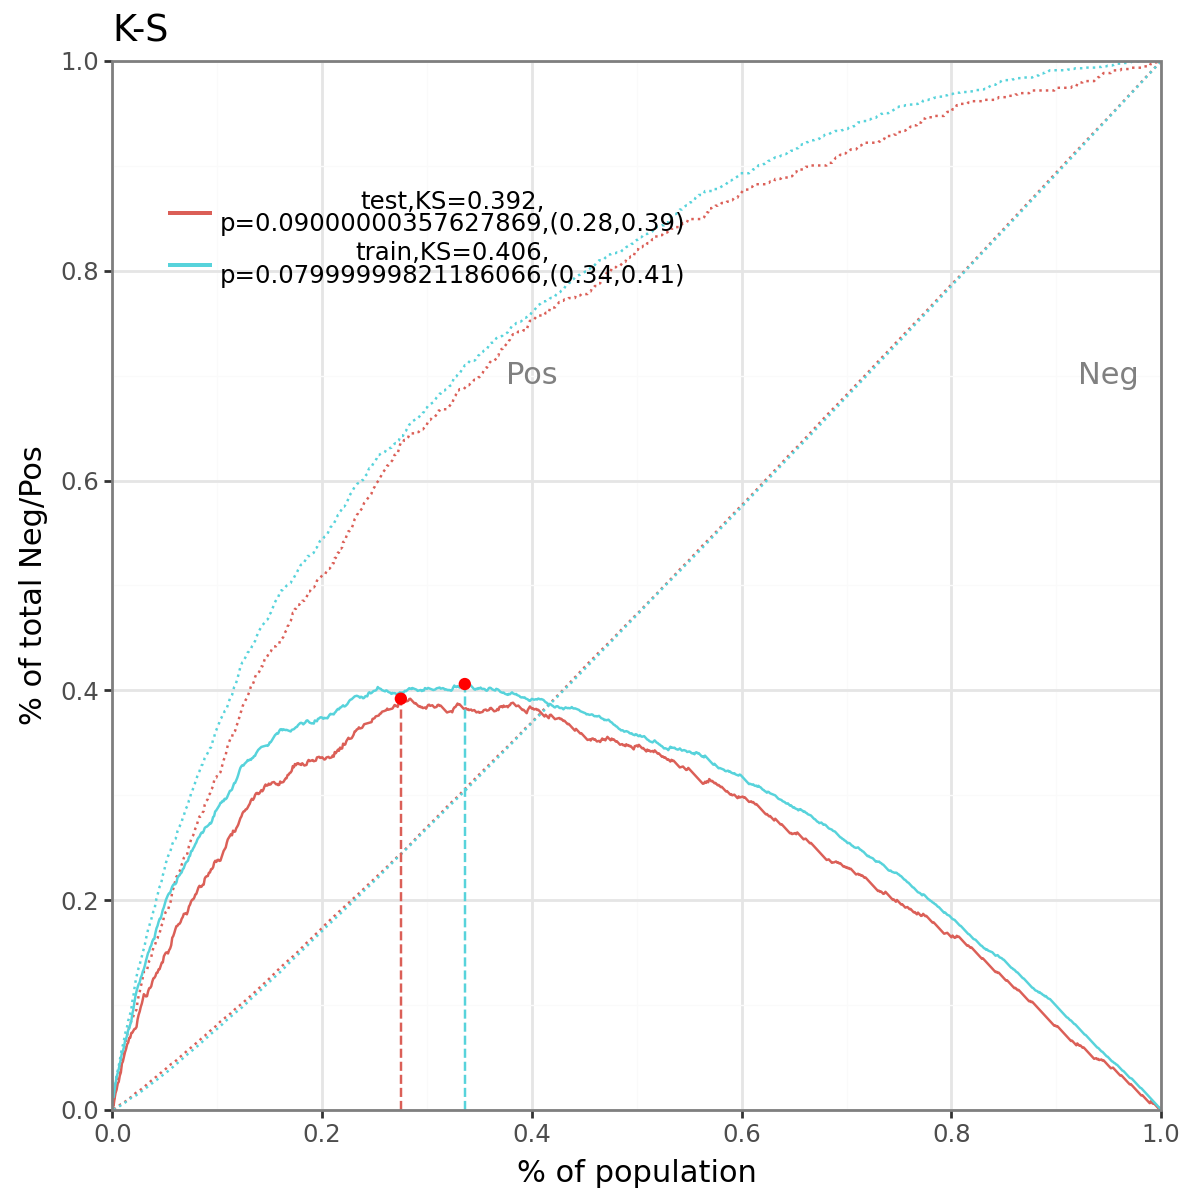

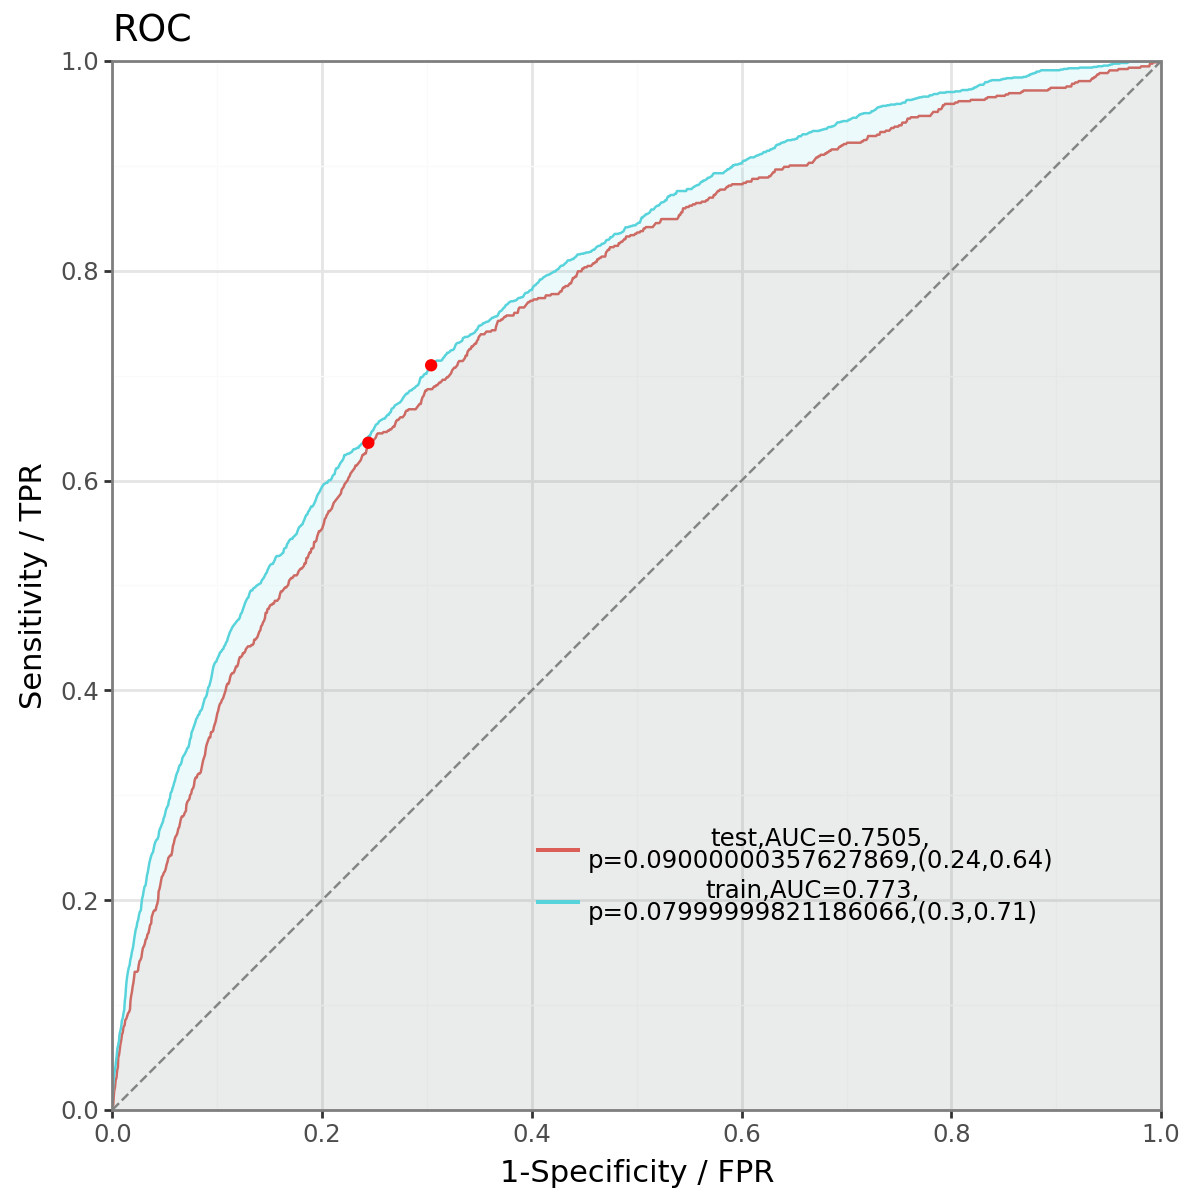

{'ks': <Figure size 600x600 with 1 Axes>,
 'roc': <Figure size 600x600 with 1 Axes>}

In [23]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(xgb.predict_proba(X_train_3_num),index=X_train.index),
    pd.Series(xgb.predict_proba(X_test_3_num),index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) 

## 6.3贝叶斯优化的LightGBM

参数空间

In [24]:
from lightgbm import LGBMClassifier
param= """{'n_estimators':trial.suggest_int('n_estimators', 100, 200),
        'boosting_type':trial.suggest_categorical("boosting_type", ["gbdt", "goss"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, log=False),
        'max_depth': trial.suggest_int('max_depth', 1, 3),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100, log=False),                 
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10.0, log=False),
        'verbosity': trial.suggest_int("verbosity",-1,-1)
         }"""  

In [25]:
%%time
lgbm=bm.BayesianCVTuner(LGBMClassifier,param,n_trials=50,cv=5,
                   scoring='auc',eval_metric='auc',random_state=114,
                   early_stopping_rounds=None,).fit(X_train_3_num,y_train)

CPU times: user 2min 41s, sys: 1min 32s, total: 4min 13s
Wall time: 40.9 s


In [26]:
lgbm.params_best #最优参数dict
#lgbm.cv_result #交叉验证结果df
#cb.model_refit #最优超参模型

{'n_estimators': 175,
 'boosting_type': 'goss',
 'learning_rate': 0.143818182893443,
 'max_depth': 1,
 'min_child_samples': 86,
 'subsample': 0.6362747123043829,
 'colsample_bytree': 0.8678053265653858,
 'reg_lambda': 6.188496410345811,
 'verbosity': -1}

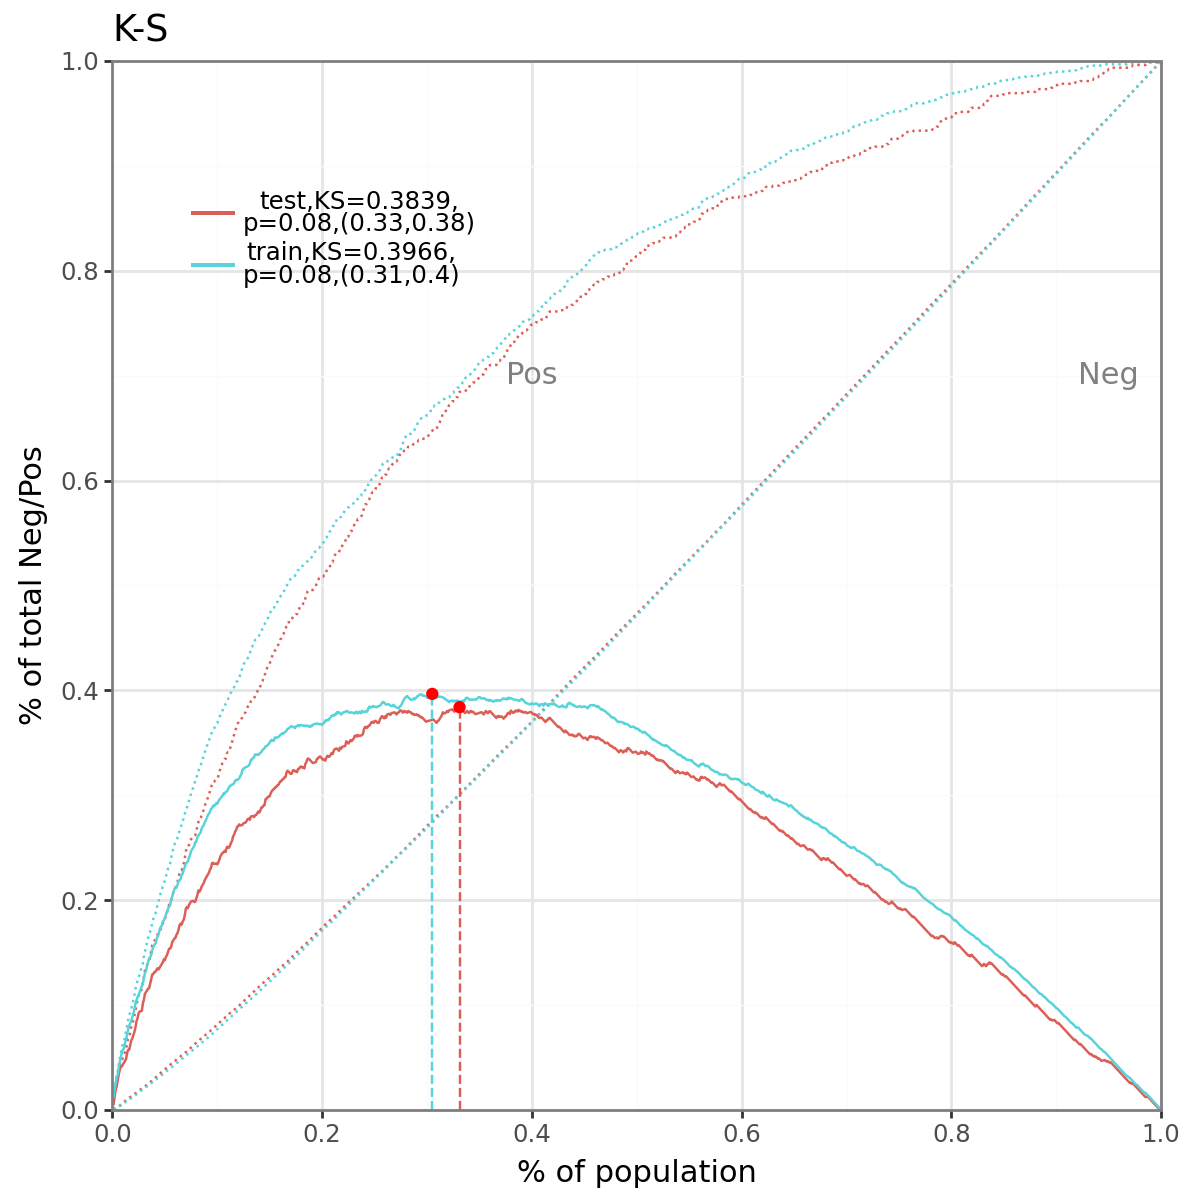

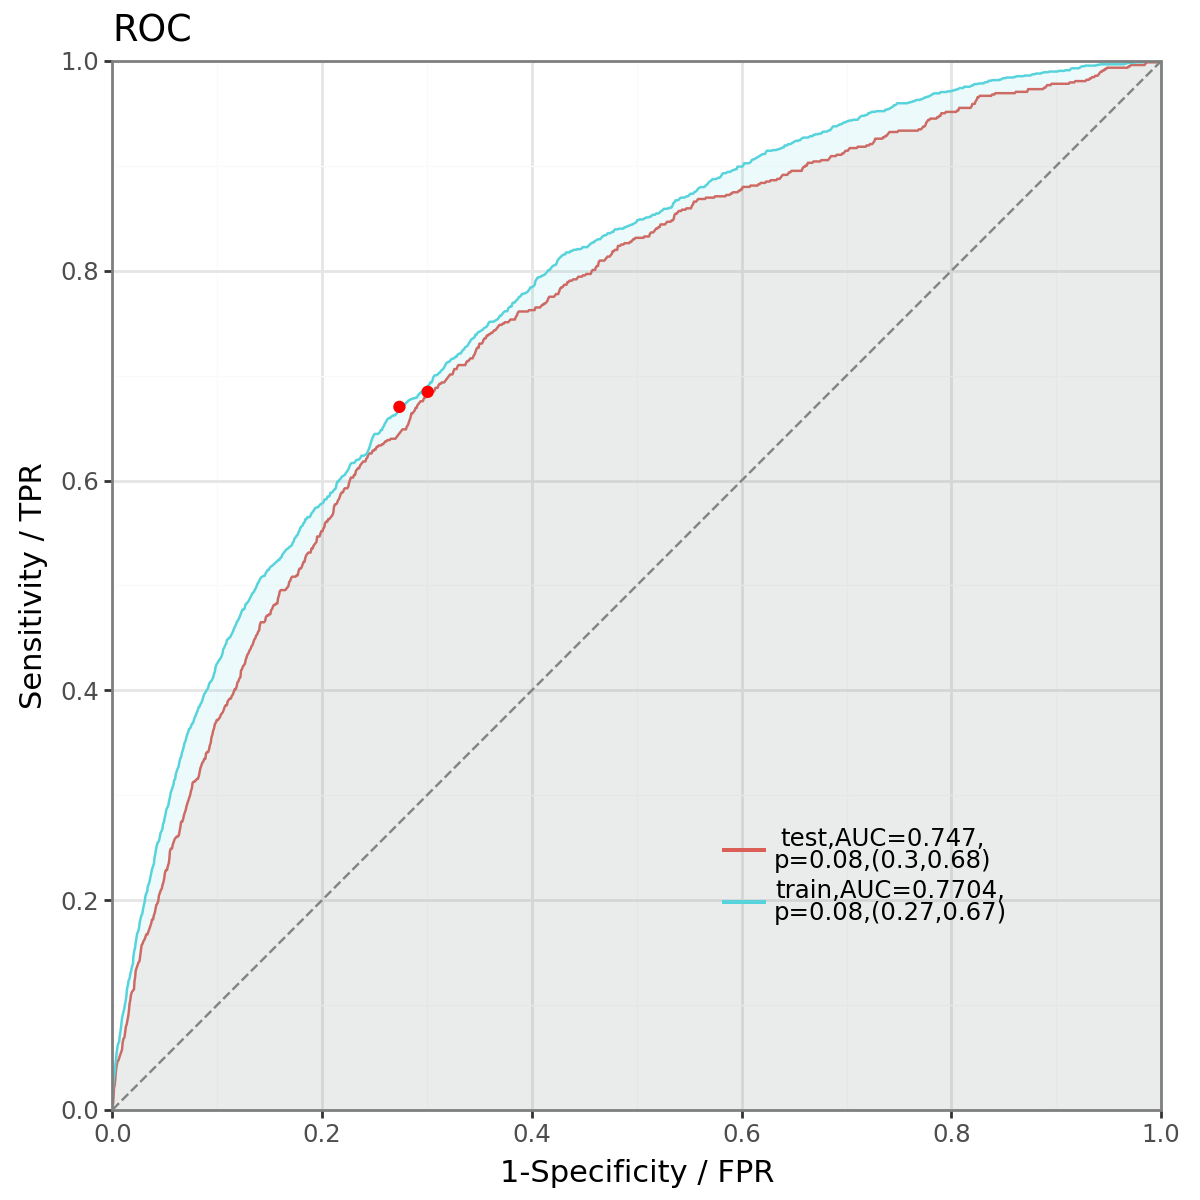

{'ks': <Figure size 600x600 with 1 Axes>,
 'roc': <Figure size 600x600 with 1 Axes>}

In [27]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(lgbm.predict_proba(X_train_3_num),index=X_train.index),
    pd.Series(lgbm.predict_proba(X_test_3_num),index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) 

## 6.4 贝叶斯优化的LightGBM-Focalloss

In [28]:
param= """{'n_estimators':trial.suggest_int('n_estimators', 30, 120),
    'boosting_type':trial.suggest_categorical("boosting_type", ["gbdt", "goss"]),
    'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3, log=False),
    'max_depth': trial.suggest_int('max_depth', 1, 4),
    'min_child_samples': trial.suggest_int('min_child_samples', 1, 100, log=False),     
    'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.02, log=False),                         
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'reg_lambda': trial.suggest_float('reg_lambda', 0, 10.0, log=False),
    'verbosity': trial.suggest_int("verbosity",-1,-1)
     }""" 

In [29]:
%%time
lgbm_fl=bm.FLBSTuner(param,gamma=2,alpha=0.25,n_trials=50,scoring='focalloss',random_state=111,
                     early_stopping_rounds=None).fit(X_train_3_num,y_train)

CPU times: user 1min 43s, sys: 1min 17s, total: 3min
Wall time: 25.1 s


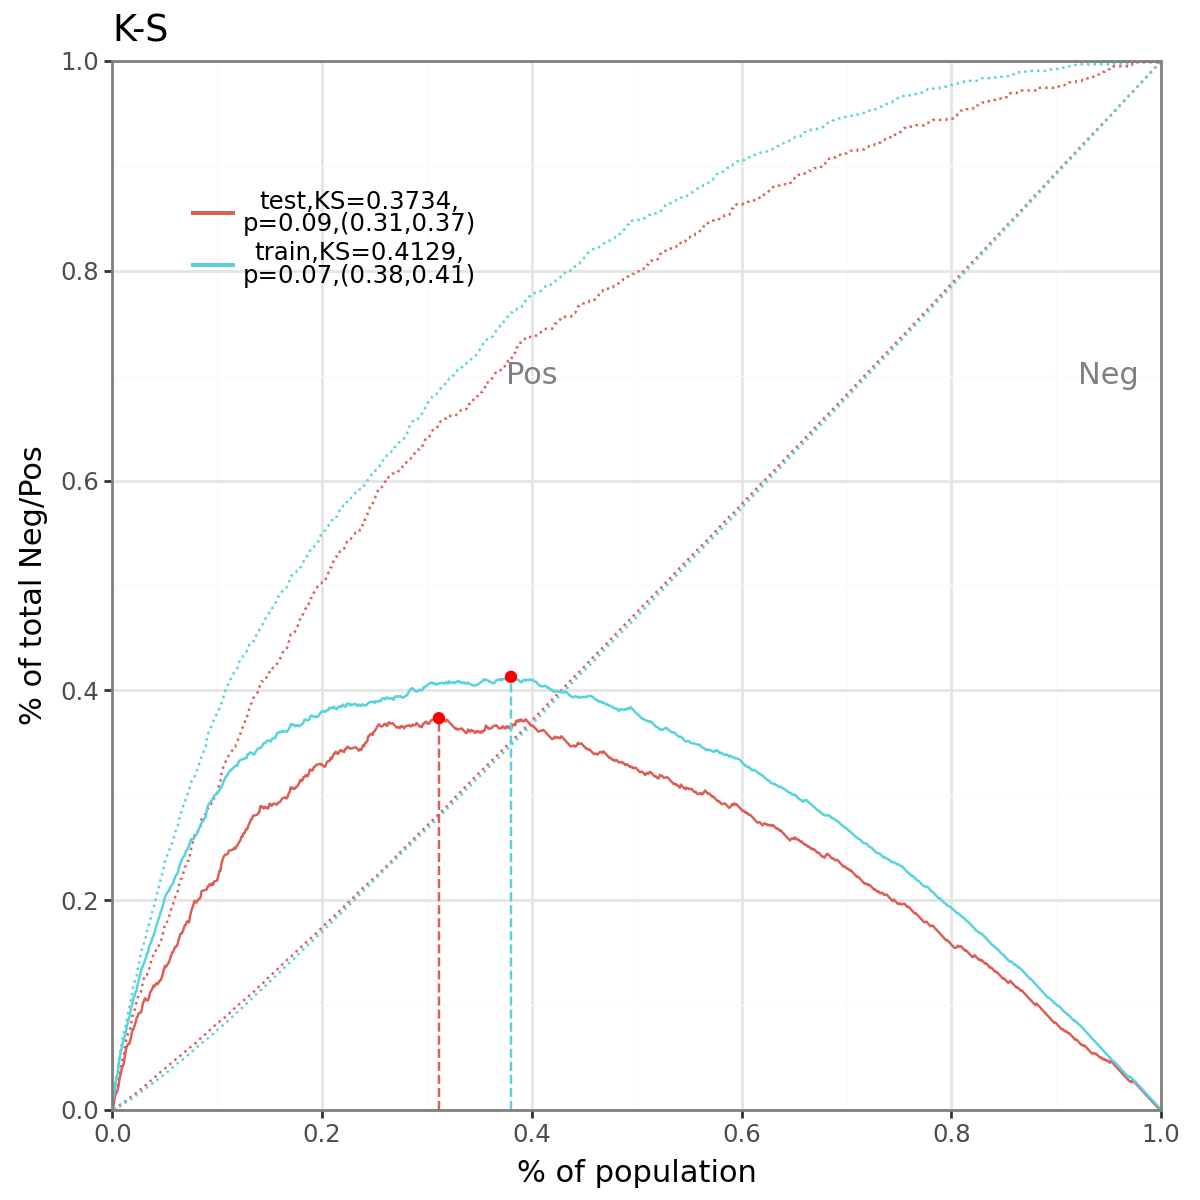

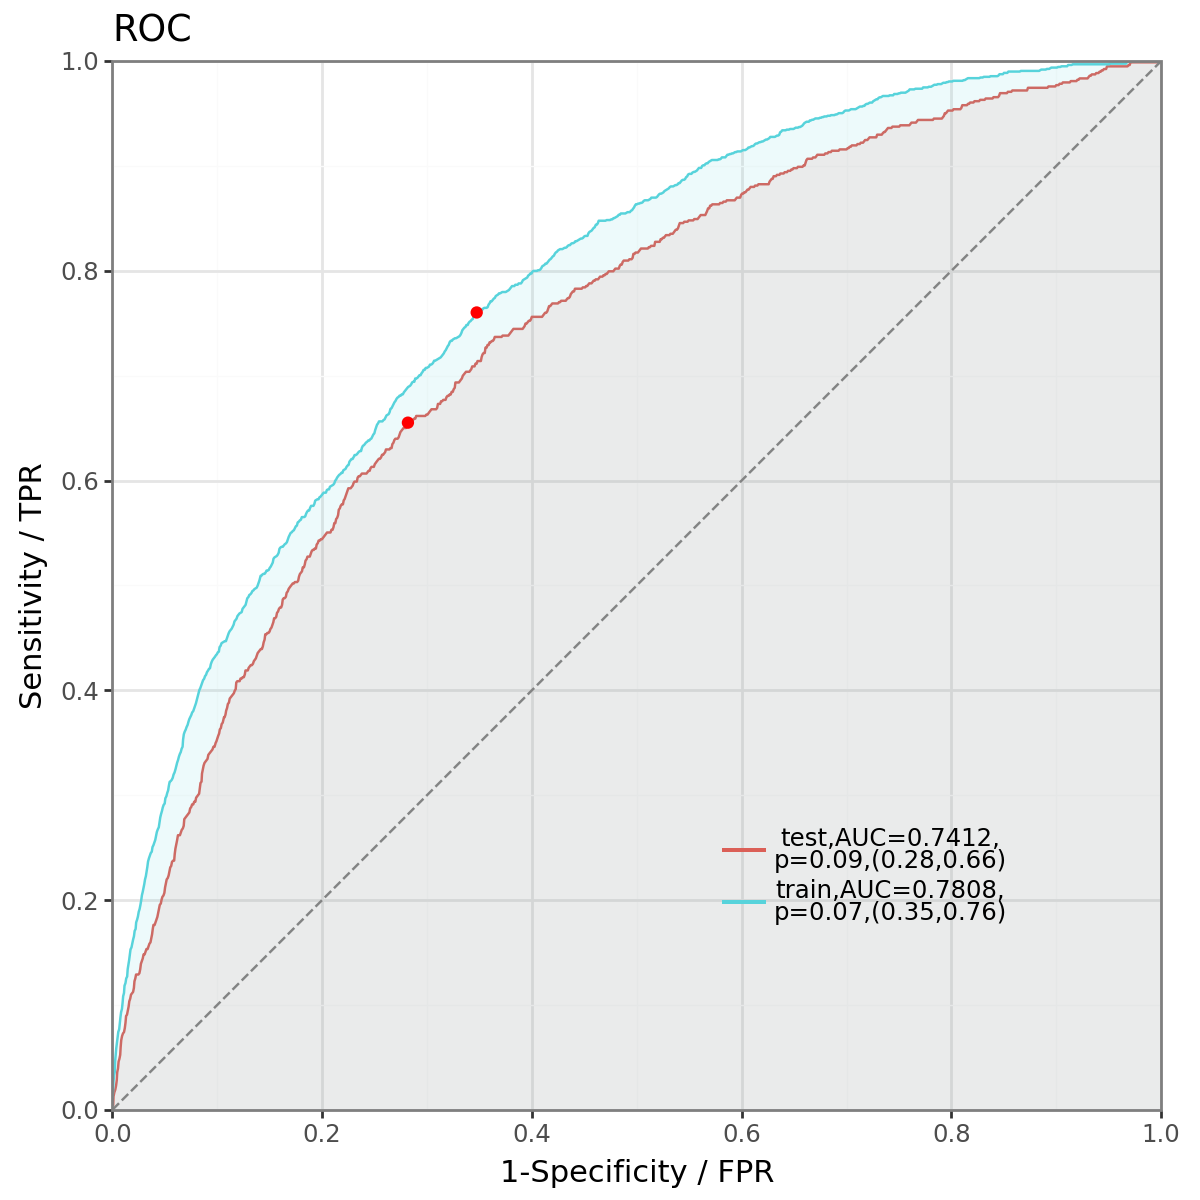

{'ks': <Figure size 600x600 with 1 Axes>,
 'roc': <Figure size 600x600 with 1 Axes>}

In [30]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(lgbm_fl.predict_proba(X_train_3_num),index=X_train.index),
    pd.Series(lgbm_fl.predict_proba(X_test_3_num),index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) 

## 6.5 贝叶斯优化的Catboost

In [31]:
from catboost import CatBoostClassifier

param= """{"iterations": trial.suggest_int("iterations",80,120),            
           "depth": trial.suggest_int("depth", 1, 3),
           "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=False),            
           "subsample": trial.suggest_float("subsample", 0.05, 1.0),
           "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.4, 1.0),
           "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
           "reg_lambda":trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
           "silent":trial.suggest_categorical("silent",[True]),
           }"""

In [34]:
%%time
cb=bm.BayesianCVTuner(CatBoostClassifier,param,n_trials=10,cv=5,
                   scoring='auc',eval_metric='auc',random_state=123,
                   early_stopping_rounds=10).fit(X_train_3_rfe,y_train,cat_features=['GENDER','EDULEVEL'])

CPU times: user 58.7 s, sys: 2.99 s, total: 1min 1s
Wall time: 11.4 s


In [35]:
cb.params_best #最优参数dict
#cb.cv_result #交叉验证结果df
#cb.model_refit #最优超参模型

{'iterations': 97,
 'depth': 3,
 'learning_rate': 0.2627615956967573,
 'subsample': 0.5349012206041106,
 'colsample_bylevel': 0.8015882697773633,
 'min_data_in_leaf': 59,
 'reg_lambda': 0.0042085405774003,
 'silent': True}

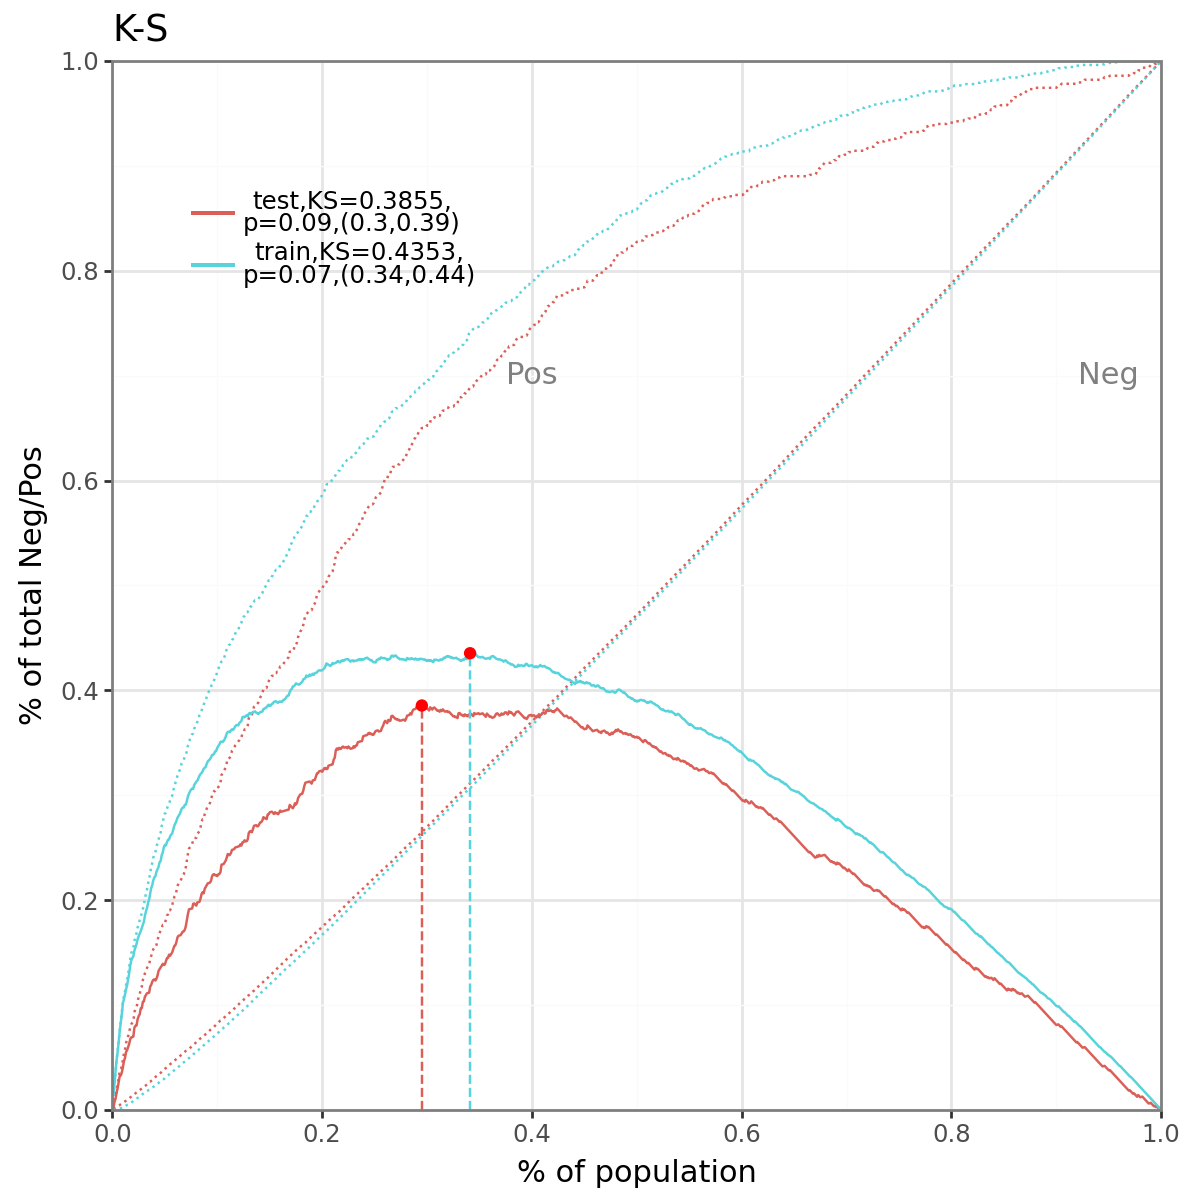

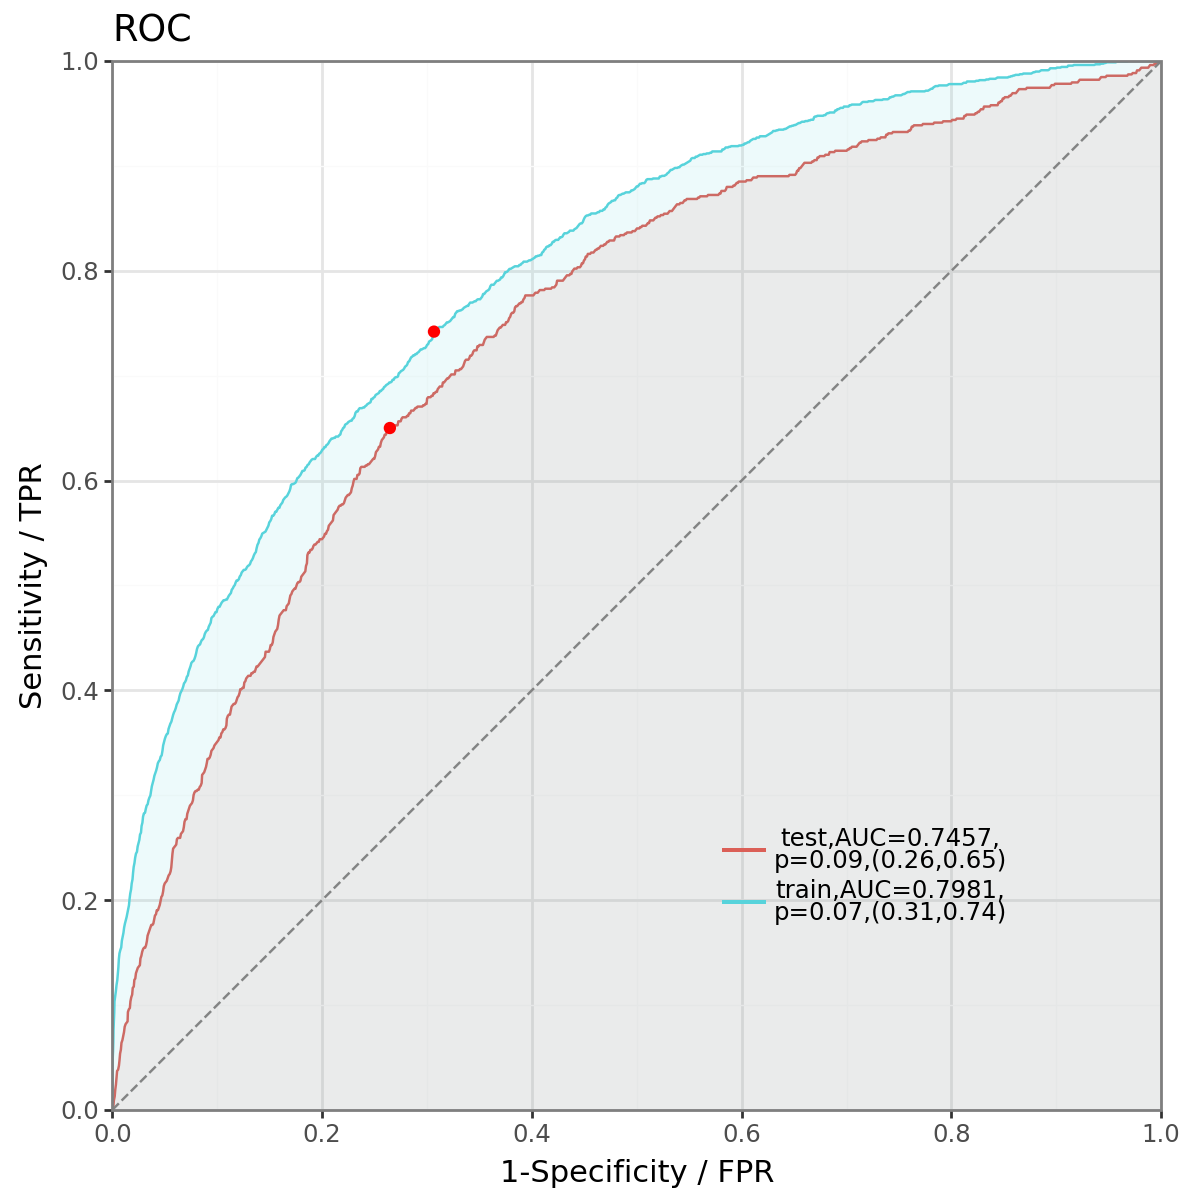

{'ks': <Figure size 600x600 with 1 Axes>,
 'roc': <Figure size 600x600 with 1 Axes>}

In [36]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(cb.predict_proba(X_train_3_rfe),index=X_train.index),
    pd.Series(cb.predict_proba(X_test_3_rfe),index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) 